In [1]:
# Using this file, we can use "import litebird_sim" even if it is not installed system-wide
import fixpythonpath

In [2]:
import argparse
import json
import numpy as np
import pylab as pl
import litebird_sim as lbs

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [10]:
file = "schema.json"

with open(file) as json_file:
    data = json.load(json_file)

# 1. Construct the bandpasses and build the sampler 

We loop over the several kind of band shape  available in `BandPassInfo`

Can't resample if no sampler is built and/or provided, initializing the sampler and interpolating the band


/home/serenagiardiello/lbs/litebird_sim/litebird_sim/bandpasses.py:271: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sp.integrate.quad(b, a=self.freqs_ghz.min(), b=inu)[0]


Can't resample if no sampler is built and/or provided, initializing the sampler and interpolating the band


/home/serenagiardiello/lbs/litebird_sim/litebird_sim/bandpasses.py:271: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sp.integrate.quad(b, a=self.freqs_ghz.min(), b=inu)[0]


Can't resample if no sampler is built and/or provided, initializing the sampler and interpolating the band
Can't resample if no sampler is built and/or provided, initializing the sampler and interpolating the band


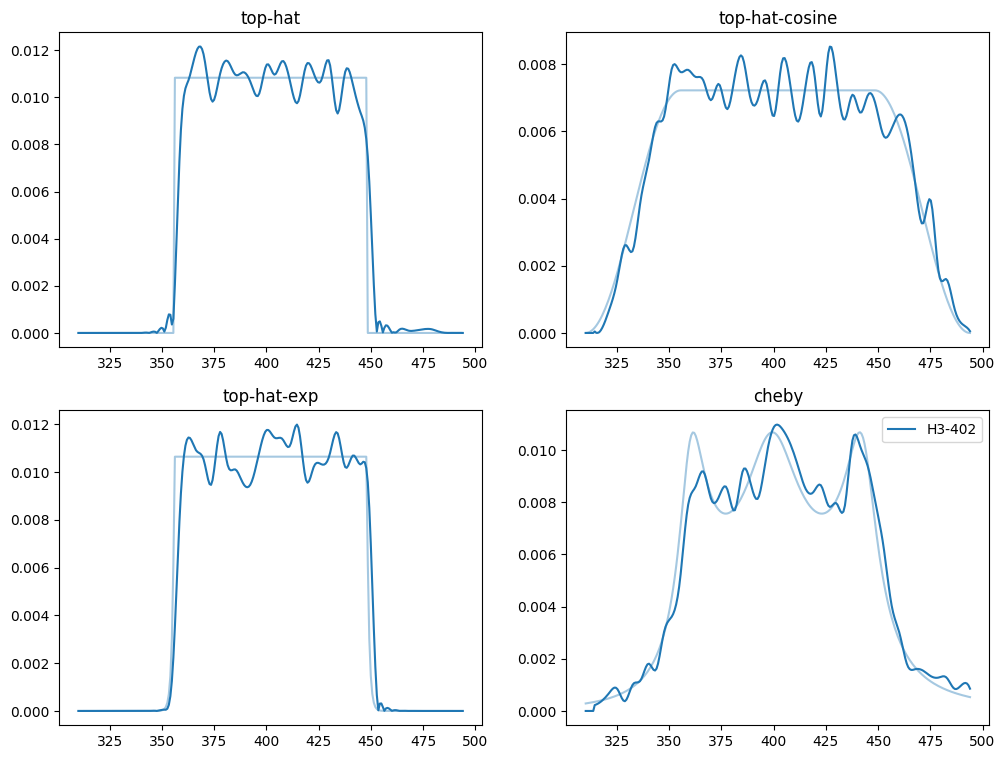

In [11]:
i = 0
pl.figure(figsize=(12, 9))
samplerbands = {}

bandcenter_ghz = data["data_files"][1]["metadata"]["bandcenter_ghz"]
bandwidth_ghz = data["data_files"][1]["metadata"]["bandwidth_ghz"]
bandname = data["data_files"][1]["metadata"]["channel"]
samplerbands[bandname] = {}

for j, btype in enumerate(["top-hat", "top-hat-cosine", "top-hat-exp", "cheby"]):
    Band = lbs.bandpasses.BandPassInfo(
        bandcenter_ghz=bandcenter_ghz,
        bandwidth_ghz=bandwidth_ghz,
        bandtype=btype,
        normalize=True,
        nsamples_inband=256,
    )  # 256
    sampled = Band.bandpass_resampling(
        nresample=50,
        bstrap_size=5000,
    )
    samplerbands[bandname][btype] = Band
    pl.subplot(221 + j)
    pl.title(btype)
    pl.plot(Band.freqs_ghz, Band.weights, alpha=0.4, color=f"C{i}")
    pl.plot(Band.freqs_ghz, sampled, color=f"C{i}", label=bandname)
pl.legend()

# 2. make per detector bpasses 
now we sample for each detector top-hat w/ an exponential cut off bandpasses. Notice that each detector will have the same centroid and bandwidth, but each band will look different, as they are different realizations of the same sampler. 


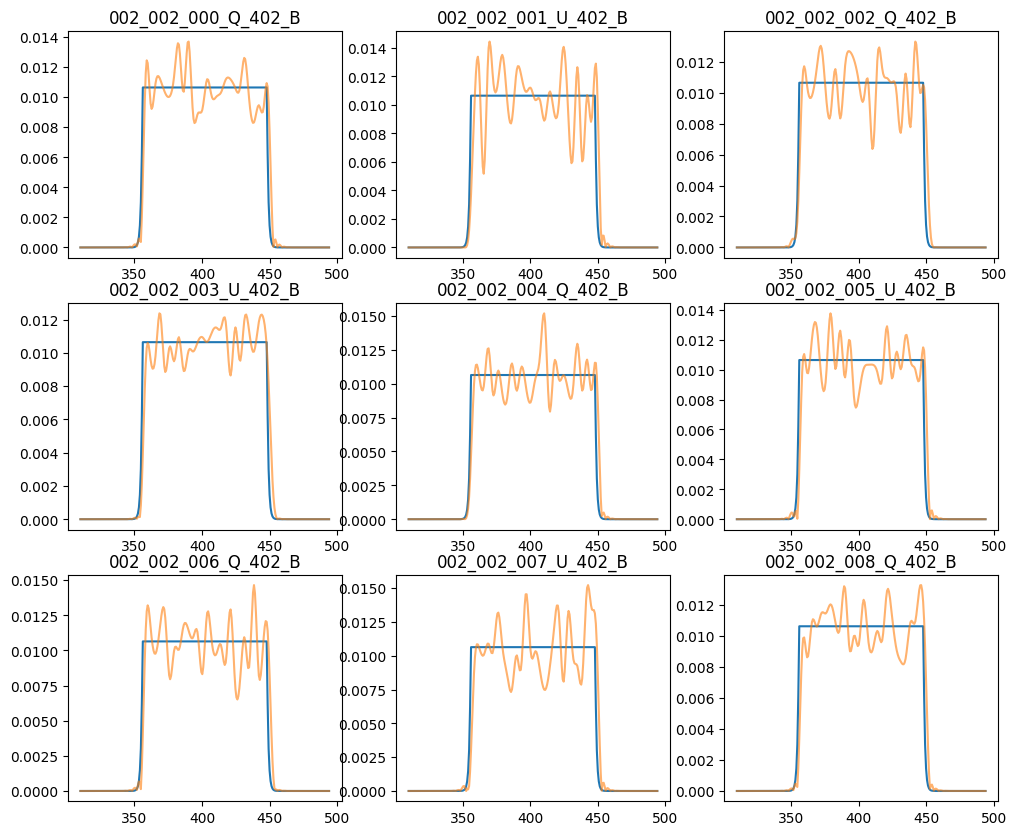

In [12]:
detectors = data["data_files"][1]["metadata"]["detector_names"]

perdet_bands = {k: {} for k in detectors}
btype = "top-hat-exp"
counter = 0
pl.figure(figsize=(12, 10))
for det in detectors:
    B = samplerbands[bandname][btype]
    perdet_bands[det] = B.bandpass_resampling()
    pl.subplot(3, 3, 1 + counter)
    pl.title(det)
    pl.plot(B.freqs_ghz, B.weights)

    pl.plot(B.freqs_ghz, perdet_bands[det], alpha=0.6)

    counter += 1
    if counter == 9:
        break